# Lensing Ray Tracing

This notebook demonstrates how to run a lensing lightcone in flowpm

In [24]:
%pylab inline 

import tensorflow as tf
import flowpm
from flowpm.tfpower import linear_matter_power
from itertools import cycle
import  DifferentiableHOS as DHOS

Populating the interactive namespace from numpy and matplotlib


/Users/dl264294/.conda/envs/env_nbody/lib/python3.8/site-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['matrix']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [5]:
# Below are a few parameters
n_lens = 22       # Number of lensplanes in the lightcone
box_size = 100.   # Transverse comoving size of the simulation volume
nc = 128          # Number of transverse voxels in the simulation volume
field_size = 5    # Size of the lensing field in degrees
field_npix = 512  # Number of pixels in the lensing field
batch_size = 1    # Number of simulations to run in parallel

In [6]:
# Instantiates a cosmology with desired parameters
cosmology = flowpm.cosmology.Planck15()

In [7]:
# Schedule the center of the lensplanes we want for ray tracing
r = tf.linspace(0., box_size*n_lens, n_lens+1)
r_center = 0.5*(r[1:] + r[:-1])

# Retrieve the scale factor corresponding to these distances
a = flowpm.tfbackground.a_of_chi(cosmology, r)
a_center =flowpm.tfbackground.a_of_chi(cosmology, r_center)

In [8]:
# this should be the redshift of our last lens
1/a[-1] - 1

<tf.Tensor: shape=(), dtype=float32, numpy=0.94021237>

In [9]:
# We run 4 steps from initial scale factor to start of raytracing
init_stages = tf.linspace(0.1, a[-1], 4)
# Then one step per lens plane
stages = tf.concat([init_stages, a_center.numpy()[::-1]], axis=0)

In [11]:
#Create some initial conditions
initial_conditions = flowpm.linear_field([nc, nc, nc],
                                         [box_size, box_size, box_size], 
                                         lambda k: tf.cast(linear_matter_power(cosmology, k), tf.complex64),         
                                         batch_size=batch_size)
initial_state = flowpm.lpt_init(cosmology, initial_conditions, 0.1)

In [12]:
# Run the Nbody
states = flowpm.nbody(cosmology, 
                      initial_state, 
                      stages,
                      [nc, nc, nc],
                      return_intermediate_states=True) 

In [15]:
# Extract the lensplanes
lensplanes = []
matrix=flowpm.raytracing.generate_matrix()
for i,j in zip(range(len(a_center)),cycle(range(6))):
    plane = flowpm.raytracing.density_plane(states[::-1][i][1],
                                            [nc, nc, nc],
                                            nc//2, #r_center[i]/box_size*nc,
                                            matrix[j],
                                            flowpm.raytracing.shift(),
                                            width=nc,
                                            plane_resolution=256)

    plane = tf.expand_dims(plane, axis=-1)
    lensplanes.append((r_center[i], states[::-1][i][0], plane[...,0]))
  

In [16]:
import astropy.units as u
xgrid, ygrid = np.meshgrid(np.linspace(0, field_size, field_npix, endpoint=False), # range of X coordinates
                           np.linspace(0, field_size, field_npix, endpoint=False)) # range of Y coordinates

coords = np.stack([xgrid, ygrid], axis=0)*u.deg
c = coords.reshape([2, -1]).T.to(u.rad)

In [17]:
# Create array of source redshifts
z_source = tf.linspace(0.5, 1, 4)

In [18]:
m = flowpm.raytracing.convergenceBorn(cosmology, 
                    lensplanes, 
                    dx=box_size/256, 
                    dz=box_size,
                    coords=c,
                    z_source=z_source)

m = m.numpy().reshape([batch_size, field_npix, field_npix, -1])

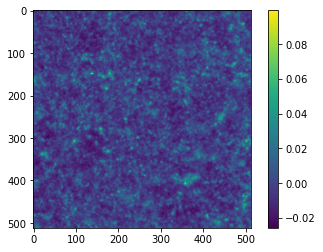

In [19]:
imshow(m[0,:,:,-1]); colorbar();

## Bonus: comparing power spectrum to theory


In [27]:
import jax
import jax_cosmo as jc
import lenstools as lt
import astropy.units as u

In [28]:
ps = np.stack([DHOS.statistics.power_spectrum(m[0,:,:,i], field_size,field_npix)[1] for i in range(len(z_source))], axis=0)
l, _ = DHOS.statistics.power_spectrum(m[0,:,:,-1],field_size,field_npix)

In [81]:
cls_th=[]
z = linspace(0,2,2048)
pz = zeros_like(z)
for i in range(len(z_source)):
    #nzs_s=jc.redshift.kde_nz(np.atleast_1d(z_source[i]), np.atleast_1d([1.]), bw=0.1)
    pz[argmin(abs(z_source[i] - z))] = 1. 
    nzs_s=jc.redshift.kde_nz(z, pz, bw=0.01)
    probes = [ jc.probes.WeakLensing([nzs_s]) ]
    cls_th.append(jc.angular_cl.angular_cl(jc.Planck15(), l.numpy(), probes))


/Users/dl264294/.local/lib/python3.8/site-packages/jax/_src/lax/lax.py:6081: UserWarning: Explicitly requested dtype <class 'jax._src.numpy.lax_numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))


Text(0.5, 1.0, 'Comparison to Jax halofit (dashed)')

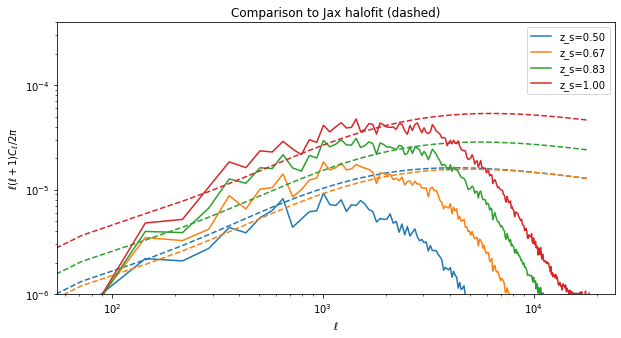

In [82]:
figure(figsize=[10,5])
for i in range(len(z_source)):
    loglog(l, l*(l+1)*ps[i]/(2*pi), color="C%d"%i, label="z_s=%0.2f"%z_source[i])
    loglog(l, l*(l+1)*cls_th[i][0]/(2*pi), '--', color="C%d"%i)
    

legend()
ylabel('$\ell(\ell+1)C_\ell /2\pi$')
ylim(1e-6,4e-4)
xlabel('$\ell$')
title('Comparison to Jax halofit (dashed)')